In [64]:
# ----------------------------------------------------------------------------
#
# TITLE - orbital_parameters.ipynb
# AUTHOR - James Lane
# PROJECT - OHStars
#
# ----------------------------------------------------------------------------
#
# Docstrings and metadata:
'''
Generate orbital parameters for the 6 outer halo stars. Sample 5D gaia kinematics with covariances and
determine orbital parameters and uncertainties using a MC approach.
'''

__author__ = "James Lane"

In [65]:
### Imports

## Basic
import numpy as np
import sys, os, pdb, warnings
from tqdm import tqdm_notebook as tqdm_nb

## Plotting
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib import cm

## Astropy
from astropy import table
from astropy import units as apu
from astropy.utils.exceptions import AstropyWarning

## galpy
from galpy import orbit
from galpy import potential
from galpy.util import bovy_coords as gpcoords
from galpy.util import bovy_conversion as gpconv
from galpy.util import bovy_plot as gpplot

# Project-specific
sys.path.append('../../src')
import ohstars.analysis
import ohstars.potential

In [66]:
### Matplotlib for notebooks
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Meta
## Future Work
- Add in extra systematic error, 0.035 mas? Following Gaia, Helmi + 2018

## Information
- Gaia co-variance information: https://www.aanda.org/articles/aa/pdf/2012/07/aa18807-12.pdf

# Preparation
## Keywords

In [67]:
# Number of samples
n_samples = 100

# Perform the analysis on all stars? False for skip
include_stars = [True, True, True, True, True, True]

# Integration keywords
t_orbit = [2,10,1,40,3,2] # Gyr

## Read Data

In [68]:
# Filename
filename = '../../data/gaia/allstars.vot'

# Read the file
with warnings.catch_warnings():
    warnings.simplefilter('ignore', AstropyWarning)
    tab = table.Table.read(filename)
###w

star_names = tab['col1'].data.astype(str)

## Prepare RV Data

In [6]:
# RV is uncorrelated with gaia so sample individually. From some Table I have (ref? In paper?)
vrad = np.array([-314.41, -136.80, -361.75, -372.09, -321.48, -214.37 ])
vrad_err = np.array([0.26,0.14,0.67,0.32,0.28,0.26])

## Write function to evaluate orbit parameters

In [60]:
def evaluate_orbit_parameters(pot, potname, n_samples, star_names, tab, vrad, vrad_err, include_stars):
    '''evaluate_orbit_parameters:
    
    Args:
    
    Returns:
        
    '''
    
    
    n_stars = len(star_names)
    n_stars_use = include_stars.count(True)
    all_stats = np.empty(n_stars_use,dtype='object')
    star_counter = 0
    
    if potname == 'McMillan2017':
        m17_ro = 8.21
        m17_vo = 233.1
    ##fi
    
    # Loop over all stars
    for i in range(n_stars):
        
        # Evaluate?
        if include_stars[i] == False:
            continue
        ##fi
        
        # Make the figure
        fig = plt.figure( figsize=(15,8) )
        axs = fig.subplots( nrows=2, ncols=3 )

        # Sample the data
        samples, _ = ohstars.analysis.sample_kinematics( tab[i], n_samples=n_samples )
        rv_samples = np.random.normal( vrad[i], vrad_err[i], size=n_samples )

        # Timing:
        n_snaps = 1000 * t_orbit[i] # 1/Myr
        times = np.linspace(0,t_orbit[i],n_snaps) * apu.Gyr

        # Arrays to hold output parameters
        peri = np.zeros(n_samples)
        apo = np.zeros(n_samples)
        Lz = np.zeros(n_samples)
        Tr = np.zeros(n_samples)
        ecc = np.zeros(n_samples)

        # Loop over the trials
        for j in tqdm_nb( range(n_samples) ):

            # Unpack the sample:
            ra, dec, par, pmra, pmdec = samples[j]
            rv = rv_samples[i]
            dist = 1/par # In kpc

            # Now declare the orbit
            if potname == 'MWPotential2014':
                o = orbit.Orbit( vxvv=[ra, dec, dist, pmra, pmdec, rv], radec=True )
            if potname == 'McMillan2017':
                o = orbit.Orbit( vxvv=[ra, dec, dist, pmra, pmdec, rv], radec=True, 
                                 ro=m17_ro, vo=m17_vo)
            ##fi

            # Integrate
            o.integrate(times, pot)

            # Output
            n_params = 5
            peri[j] = o.rperi().value # Kpc
            apo[j] = o.rap().value # Kpc
            Lz[j] = np.average( o.vT(times) * o.R(times) ).value # Kpc Km/s
            if potname == 'MWPotential2014':
                Tr[j] = o.Tr(pot=pot, type='staeckel').value # Gyr
                ecc[j] = o.e(pot=pot, type='staeckel') # unitless
            if potname == 'McMillan2017':
                Tr[j] = o.Tr(pot=pot, type='staeckel', delta=0.45).value # Gyr
                ecc[j] = o.e(pot=pot, type='staeckel', delta=0.45) # unitless
            ##fi

        # Determine values to plot and calculate
        plot_params = np.array([peri,apo,Lz,Tr,ecc])
        plot_labels = np.array([r'$r_{peri}$ [kpc]',
                                r'$r_{apo}$ [kpc]',
                                r'$L_{z}$ [kpc km/s]',
                                r'$T_{rad} [Gyr]$',
                                r'$e$']) 
        plot_labels_plain = np.array(['rp [kpc]','rapo [kpc]','Lz [kpc km/s]','Tr [Gyr]','eccen.'])

        # Arrays for statistics
        stats_arr = np.zeros((5,3))
        
        for k in range(n_params):
            
            # Get parameter and compute statistics
            param = plot_params[k]
            param_median = np.median(param)
            param_c68p_l = np.sort(param)[int(0.16*n_samples)]
            param_c68p_u = np.sort(param)[int(0.84*n_samples)]
            
            stats_arr[k,0] = param_median
            stats_arr[k,1] = param_median-param_c68p_l
            stats_arr[k,2] = param_c68p_u-param_median
            
        ###k
        
        # Loop over all axes
        for k in range(3):
            for l in range(2):
                
                if 2*k+l > n_params-1: 
                    axs[l,k].set_axis_off()
                    continue
                
                # Get parameter and compute statistics
                param = plot_params[2*k+l]    
                param_median = np.median(param)
                param_c68p_l = np.sort(param)[int(0.16*n_samples)]
                param_c68p_u = np.sort(param)[int(0.84*n_samples)]

                # Make histograms
                bin_n, bins = np.histogram( param )
                axs[l,k].step(bins[:-1], bin_n, where='post', color='Black')
                axs[l,k].plot([bins[-2],bins[-1]], [bin_n[-1],bin_n[-1]], color='Black')
                axs[l,k].axvline( param_median, linestyle='solid', color='Red', linewidth=0.5 )
                axs[l,k].axvline( param_c68p_l, linestyle='dashed', color='Red', linewidth=0.5 )
                axs[l,k].axvline( param_c68p_u, linestyle='dashed', color='Red', linewidth=0.5 )
                axs[l,k].set_xlim( np.min(param), np.max(param) )
                axs[l,k].set_xlabel(plot_labels[2*k+l], fontsize=16)
                axs[l,k].set_ylabel('N', fontsize=16)

        fig.savefig('plots/'+potname+'/'+star_names[i]+'_orbital_param_pdf.pdf')
        fig.suptitle(star_names[i], fontsize=20)

        plt.show()
        plt.close('all')
        
        # Print information to screen and file
        outfile = open('./orbital_parameters/'+potname+'/'+star_names[i]+'_orbital_param.txt','w')
        outfile.write('# '+plot_labels_plain[0]+', '+plot_labels_plain[1]+', '+plot_labels_plain[2]+', '+plot_labels_plain[3]+': median, -err, +err\n')
        
        print(star_names[i])
        print('========')
        for k in range(n_params):
            print(plot_labels_plain[k])
            print('Median: '+str( round(stats_arr[k,0],4)) )
            print('Central 68th percentile: ['+str(round(stats_arr[k,0]-stats_arr[k,1],4))+','+str(round(stats_arr[k,0]-stats_arr[k,1],4))+']')
            print('Errors: ['+str(round(stats_arr[k,1],4))+','+str(round(stats_arr[k,2],4))+']\n')
        ###k
        
        outfile.close()
        
        all_stats[star_counter] = stats_arr
        star_counter += 1
    
    # No output
    return all_stats

#def

def make_latex_table(stats, star_names, filename):
    
    fileout = open(filename, 'w')
    
    n_stars = len(stats)
    n_params = stats[0].shape[0]
    
    # Assuming 5 parameters
    fileout.write('Name & $r_{peri}$ [kpc] & $r_{apo}$ [kpc] & $L_{z}$ [kpc km/s] & $T_{rad} [Gyr]$ & $e$ \\ \n')
    fileout.write('\hline \n')
    
    def stround(num,nround):
        return str(round(num,nround))
    
    for i in range( n_stars ):
        
        fileout.write( star_names[i] + ' & ' )
        
        for j in range( n_params ):
            
            fileout.write('$' + stround(stats[i][j,0],3) +\
                          '^{+' + stround(stats[i][j,1],3) + '}' +\
                          '_{-' + stround(stats[i][j,2],3) + '}$' +\
                          ' & ')
        ###j
        fileout.write('\\ \n')
    ###i
    fileout.write('\hline \n')
    fileout.close()
#def

# Determine Orbital Parameters
Use different potentials. Start with MWPotential2014 then use McMillan 2017

## MWPotential2014
Loop over each star and determine orbital parameters

A Jupyter Widget

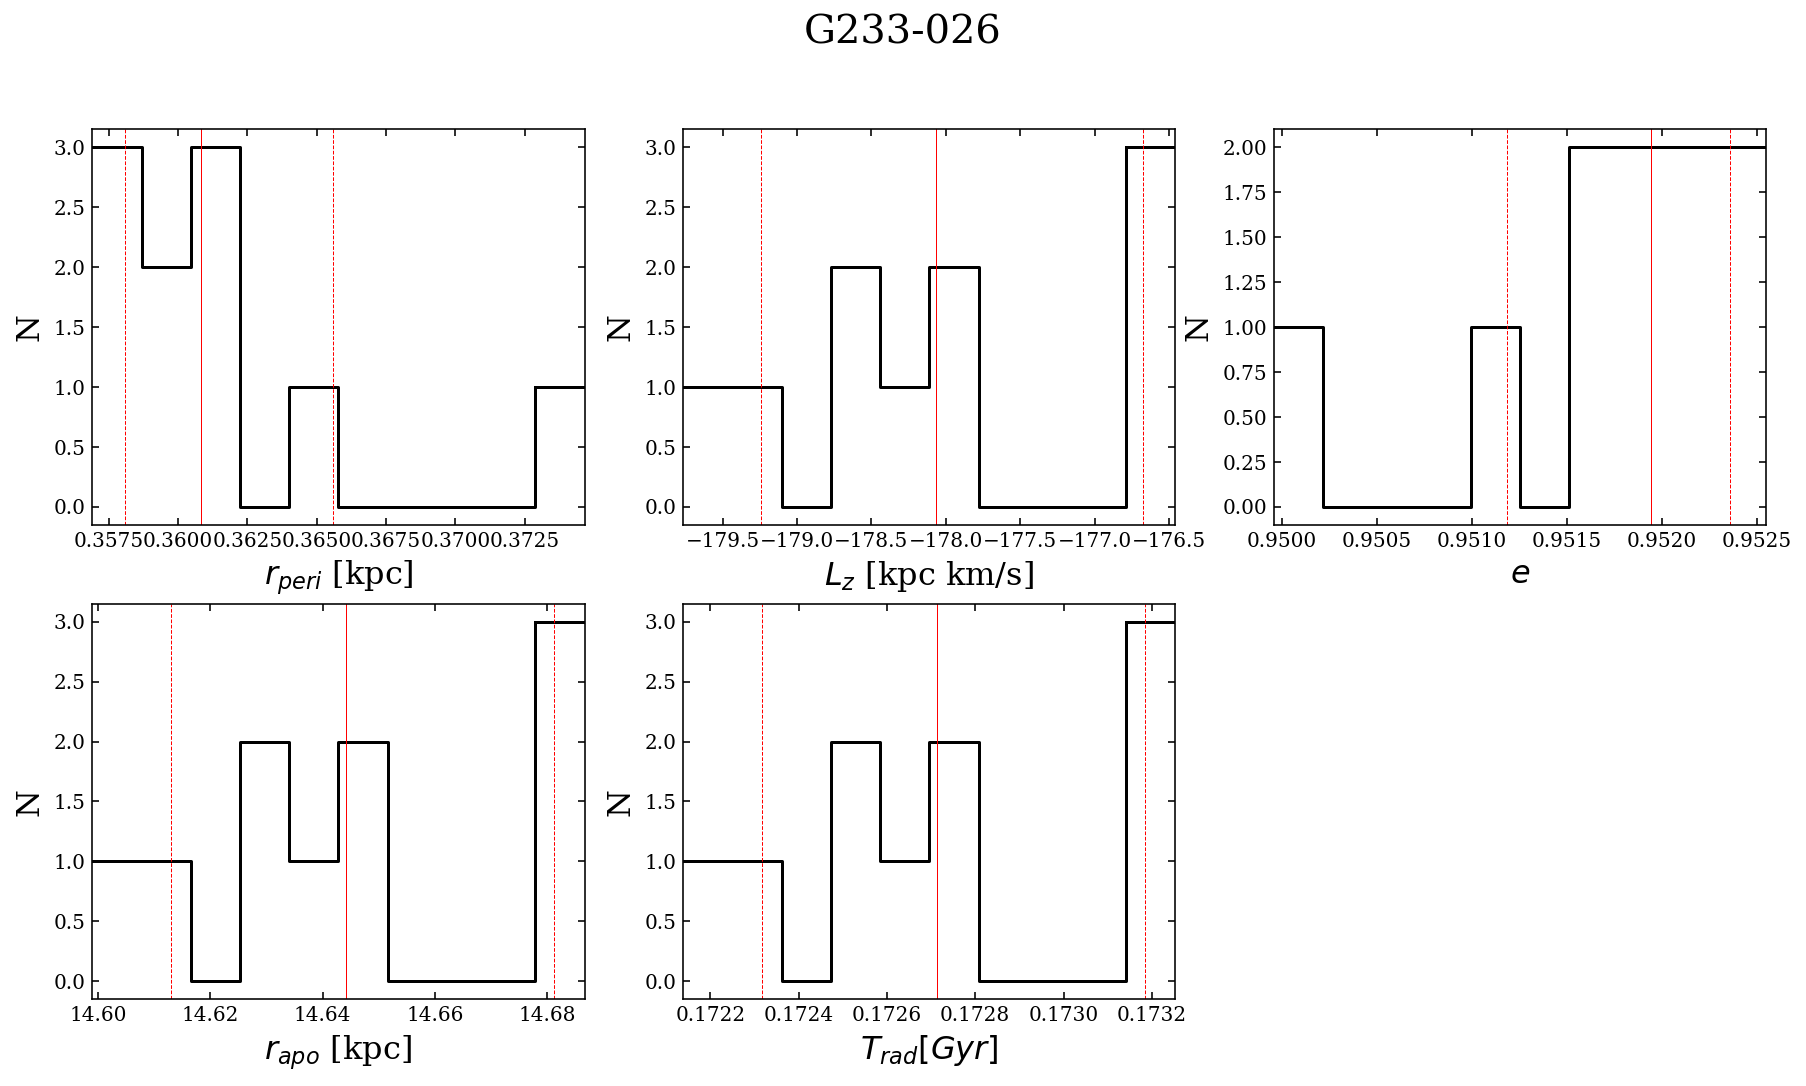

G233-026
rp [kpc]
Median: 0.3608
Central 68th percentile: [0.3581,0.3581]
Errors: [0.0027,0.0048]

rapo [kpc]
Median: 14.6442
Central 68th percentile: [14.6131,14.6131]
Errors: [0.0312,0.037]

Lz [kpc km/s]
Median: -178.0657
Central 68th percentile: [-179.2404,-179.2404]
Errors: [1.1747,1.3931]

Tr [Gyr]
Median: 0.1727
Central 68th percentile: [0.1723,0.1723]
Errors: [0.0004,0.0005]

eccen.
Median: 0.9519
Central 68th percentile: [0.9512,0.9512]
Errors: [0.0008,0.0004]



A Jupyter Widget

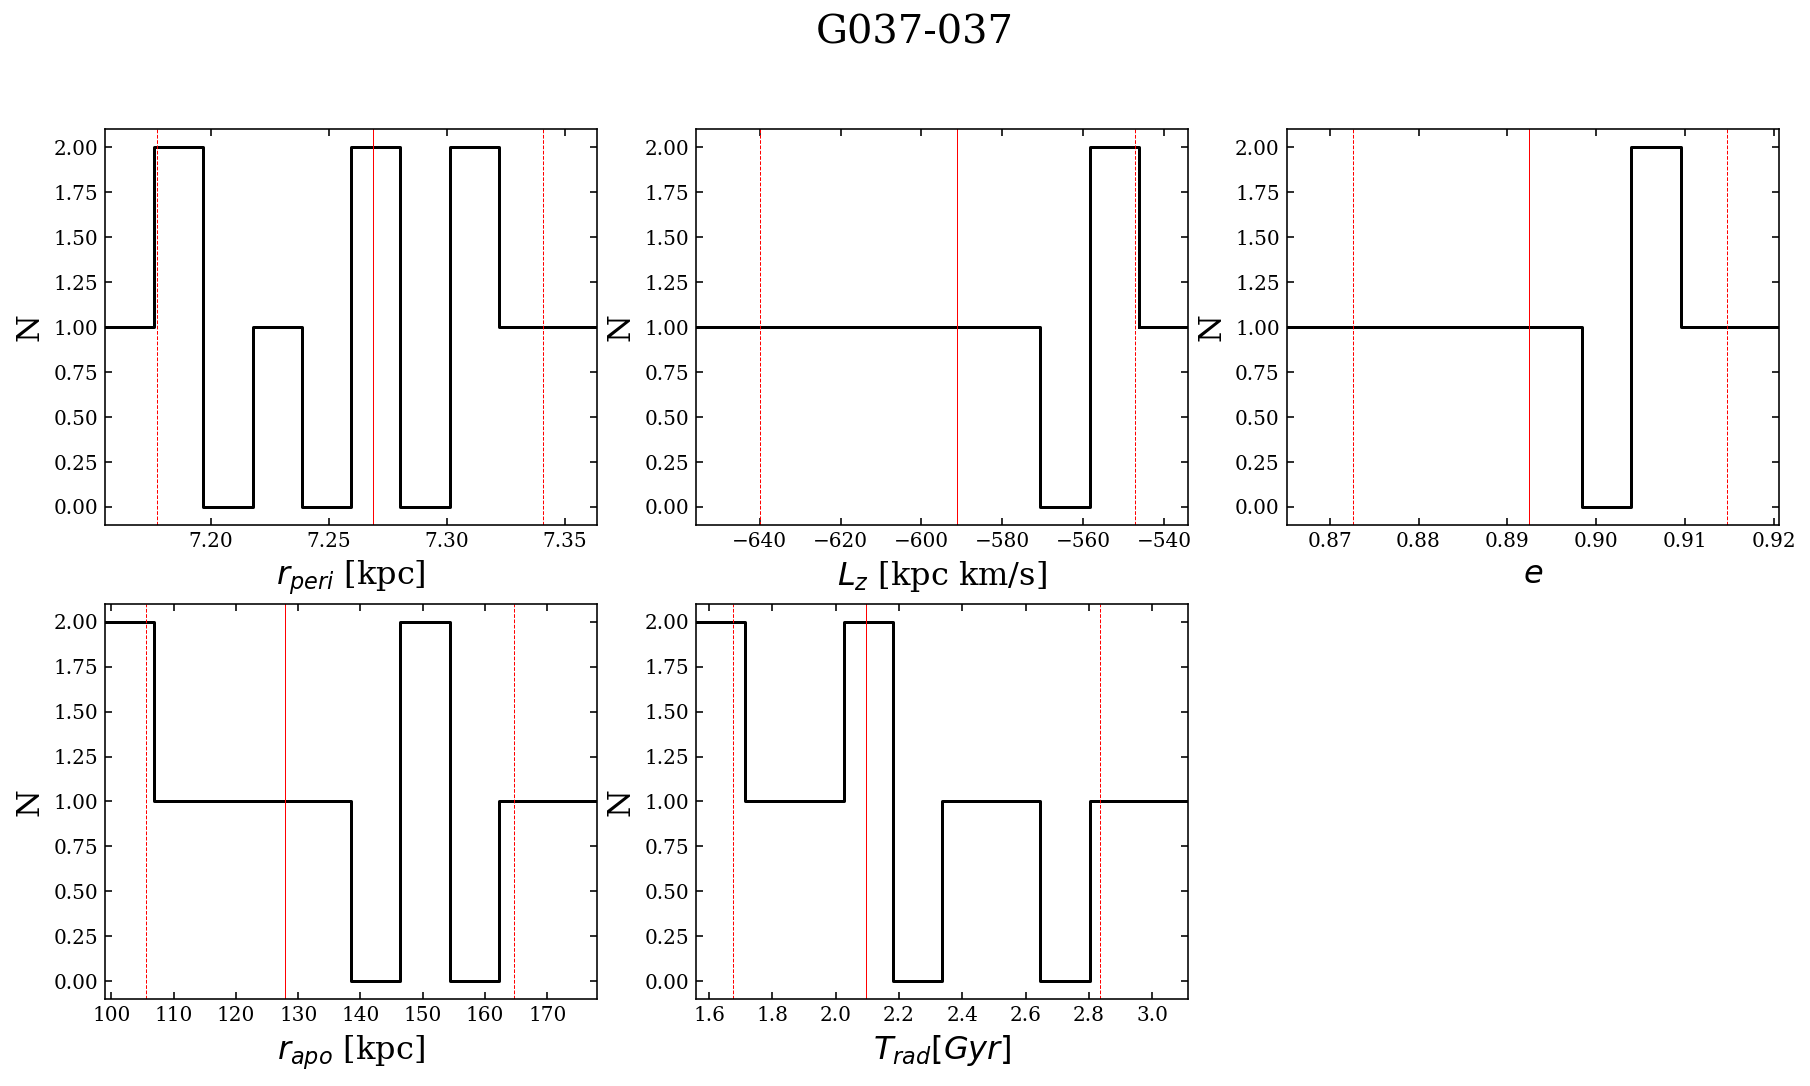

G037-037
rp [kpc]
Median: 7.2685
Central 68th percentile: [7.1773,7.1773]
Errors: [0.0912,0.0721]

rapo [kpc]
Median: 127.8765
Central 68th percentile: [105.4924,105.4924]
Errors: [22.3841,36.8682]

Lz [kpc km/s]
Median: -591.2941
Central 68th percentile: [-639.9716,-639.9716]
Errors: [48.6775,44.1564]

Tr [Gyr]
Median: 2.0966
Central 68th percentile: [1.6765,1.6765]
Errors: [0.4201,0.7373]

eccen.
Median: 0.8924
Central 68th percentile: [0.8726,0.8726]
Errors: [0.0198,0.0223]



A Jupyter Widget

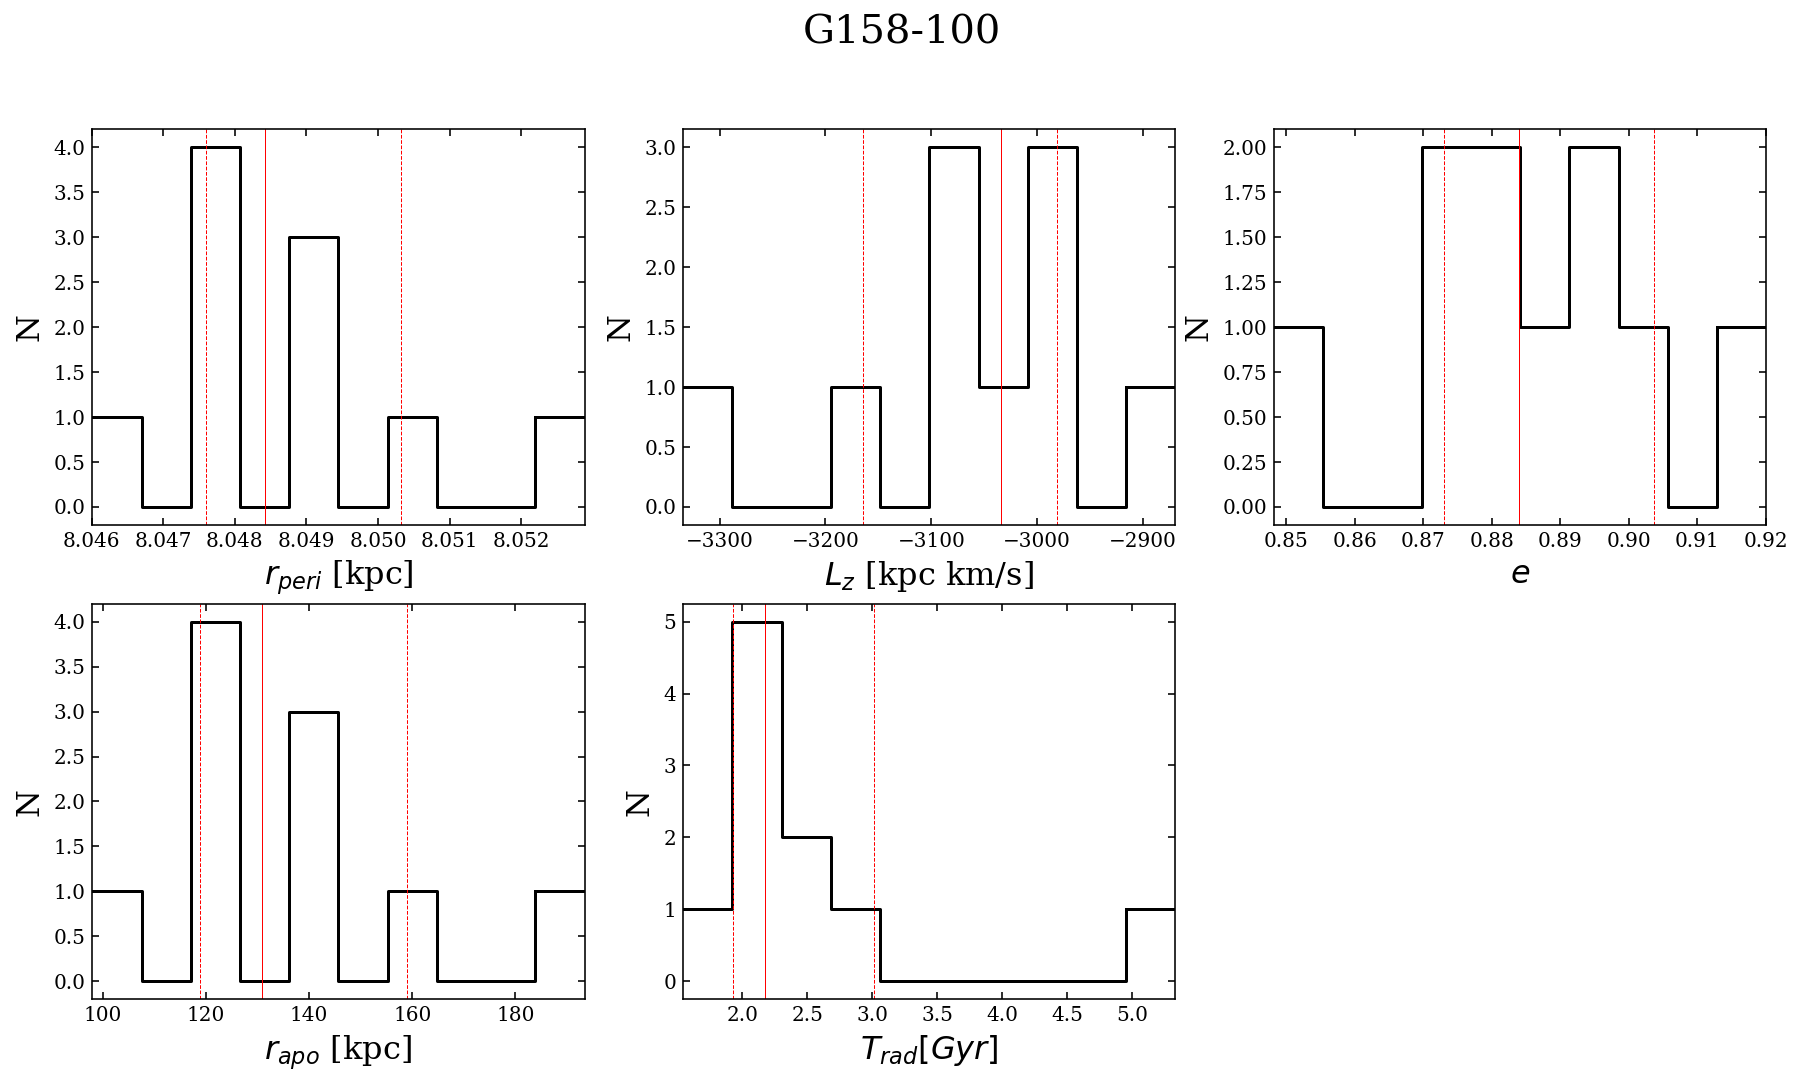

G158-100
rp [kpc]
Median: 8.0484
Central 68th percentile: [8.0476,8.0476]
Errors: [0.0008,0.0019]

rapo [kpc]
Median: 130.8811
Central 68th percentile: [118.7745,118.7745]
Errors: [12.1066,28.1469]

Lz [kpc km/s]
Median: -3034.2949
Central 68th percentile: [-3164.478,-3164.478]
Errors: [130.1831,53.2263]

Tr [Gyr]
Median: 2.1745
Central 68th percentile: [1.9258,1.9258]
Errors: [0.2487,0.843]

eccen.
Median: 0.8839
Central 68th percentile: [0.8731,0.8731]
Errors: [0.0109,0.0197]



A Jupyter Widget

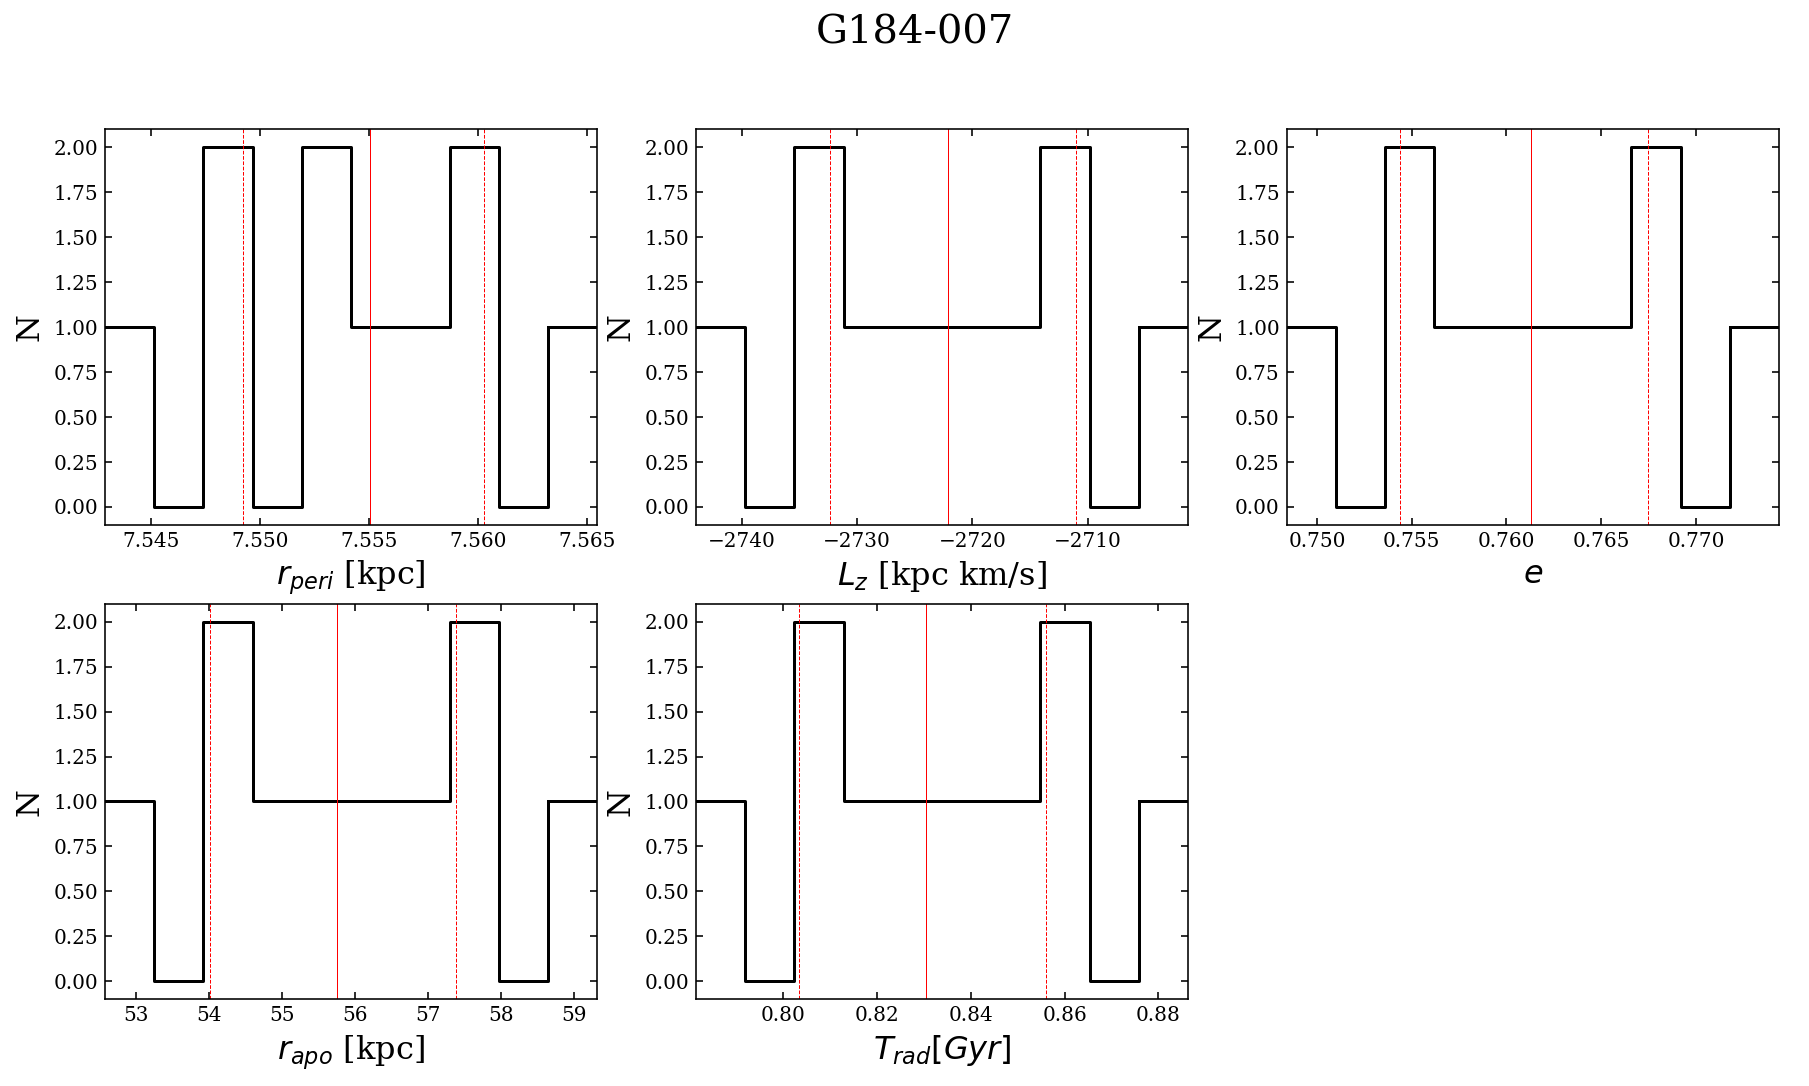

G184-007
rp [kpc]
Median: 7.5551
Central 68th percentile: [7.5492,7.5492]
Errors: [0.0059,0.0052]

rapo [kpc]
Median: 55.7487
Central 68th percentile: [54.0083,54.0083]
Errors: [1.7404,1.6398]

Lz [kpc km/s]
Median: -2722.1357
Central 68th percentile: [-2732.3792,-2732.3792]
Errors: [10.2435,11.1342]

Tr [Gyr]
Median: 0.8304
Central 68th percentile: [0.8034,0.8034]
Errors: [0.027,0.0256]

eccen.
Median: 0.7613
Central 68th percentile: [0.7544,0.7544]
Errors: [0.0069,0.0062]



A Jupyter Widget

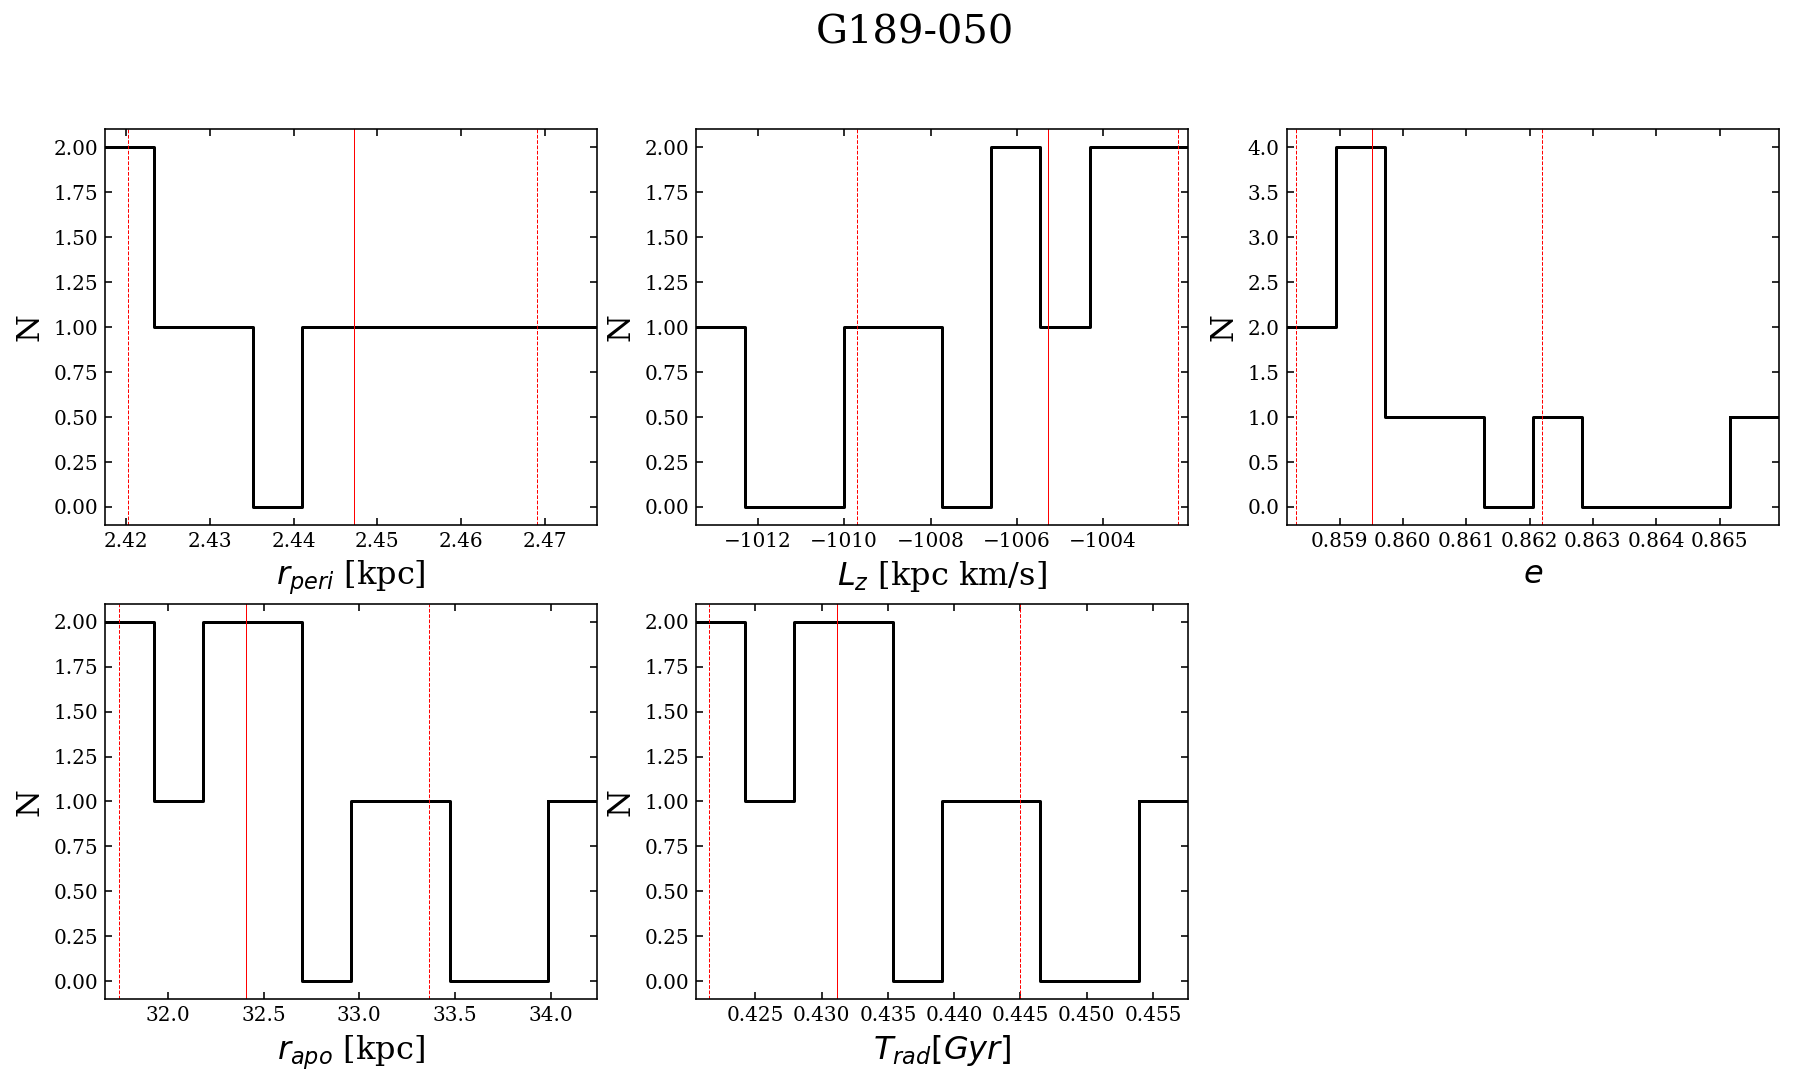

G189-050
rp [kpc]
Median: 2.4472
Central 68th percentile: [2.4203,2.4203]
Errors: [0.0269,0.0219]

rapo [kpc]
Median: 32.4062
Central 68th percentile: [31.7424,31.7424]
Errors: [0.6638,0.9576]

Lz [kpc km/s]
Median: -1005.2741
Central 68th percentile: [-1009.6973,-1009.6973]
Errors: [4.4232,3.0132]

Tr [Gyr]
Median: 0.4312
Central 68th percentile: [0.4215,0.4215]
Errors: [0.0096,0.0138]

eccen.
Median: 0.8595
Central 68th percentile: [0.8583,0.8583]
Errors: [0.0012,0.0027]



A Jupyter Widget

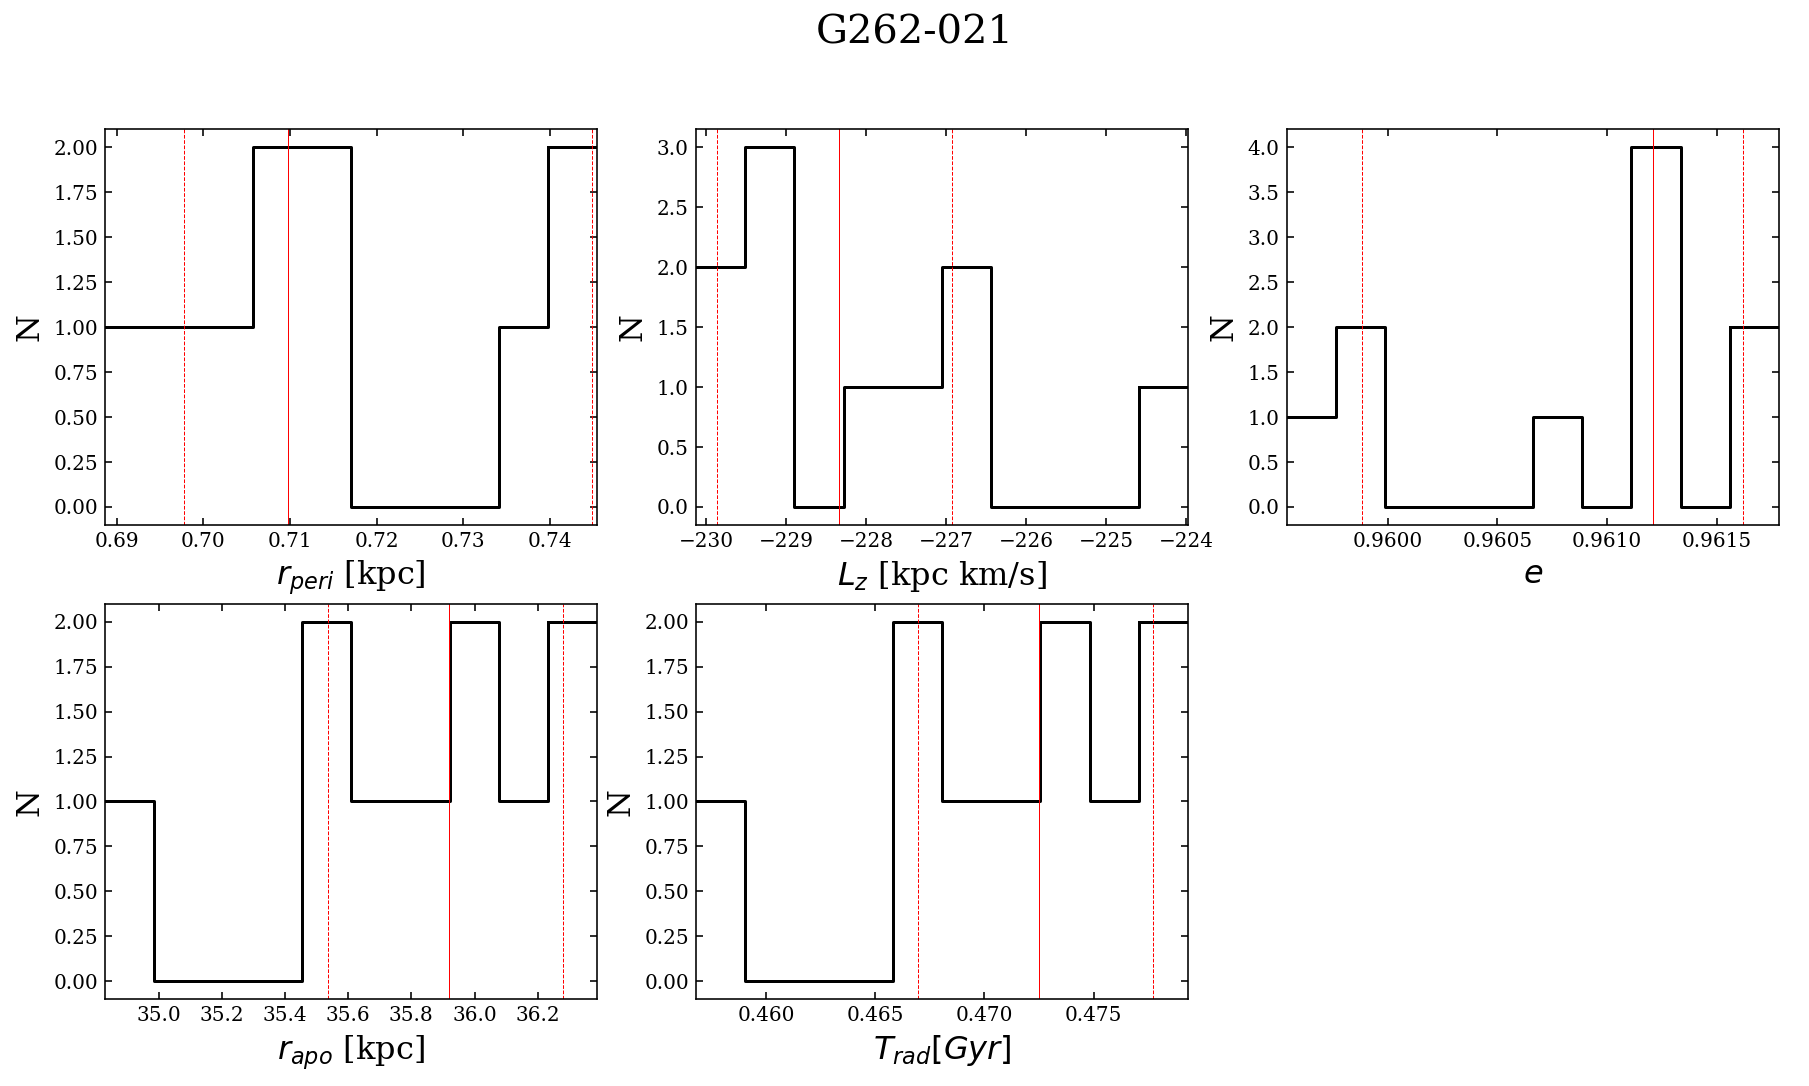

G262-021
rp [kpc]
Median: 0.7098
Central 68th percentile: [0.6977,0.6977]
Errors: [0.0121,0.035]

rapo [kpc]
Median: 35.9184
Central 68th percentile: [35.5363,35.5363]
Errors: [0.3821,0.36]

Lz [kpc km/s]
Median: -228.3379
Central 68th percentile: [-229.8642,-229.8642]
Errors: [1.5263,1.4155]

Tr [Gyr]
Median: 0.4725
Central 68th percentile: [0.467,0.467]
Errors: [0.0055,0.0052]

eccen.
Median: 0.9612
Central 68th percentile: [0.9599,0.9599]
Errors: [0.0013,0.0004]



In [63]:
# Evaluate
mw2014_stats = evaluate_orbit_parameters(potential.MWPotential2014, 'MWPotential2014', 
                          10, star_names, tab, vrad, vrad_err, 
                          include_stars)
make_latex_table( mw2014_stats, star_names, filename='MWPotential2014.txt' )


## A Second Potential
Loop over each star and determine orbital parameters

A Jupyter Widget

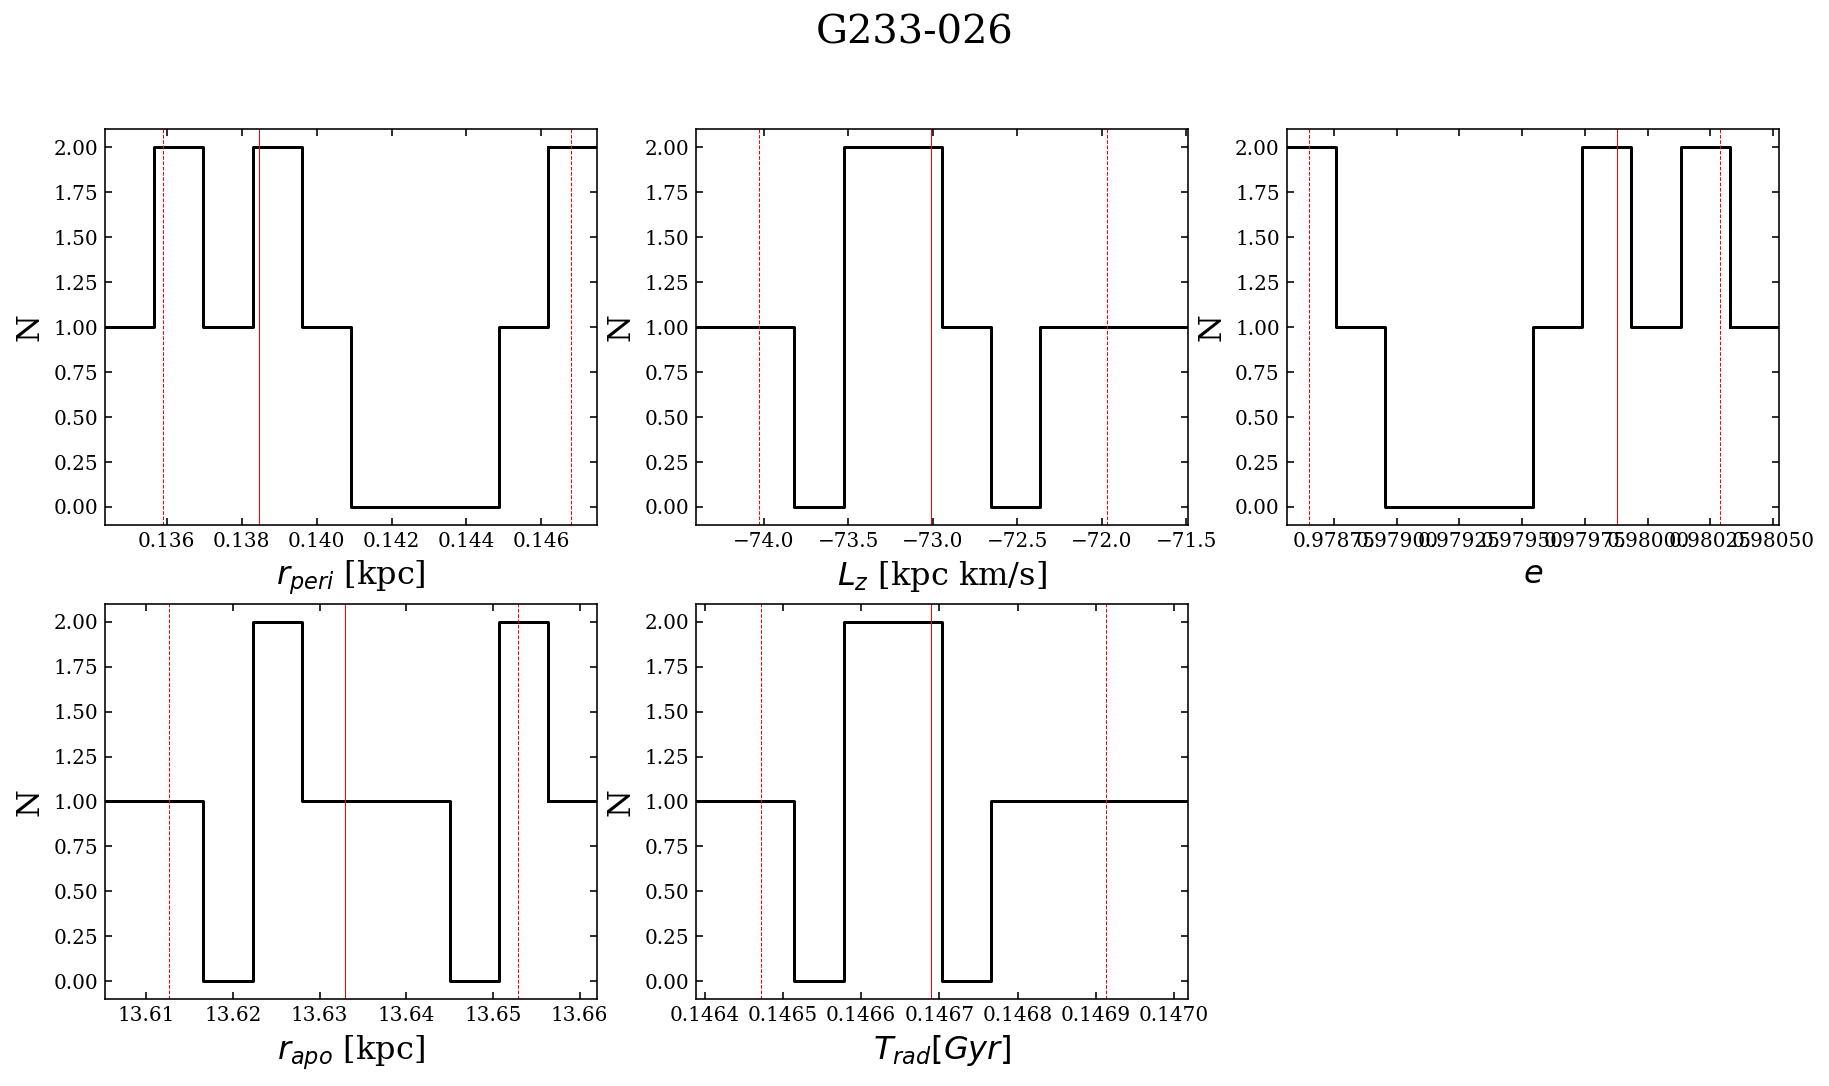

G233-026
rp [kpc]
Median: 0.1385
Central 68th percentile: [0.1359,0.1359]
Errors: [0.0026,0.0083]

rapo [kpc]
Median: 13.6329
Central 68th percentile: [13.6127,13.6127]
Errors: [0.0203,0.02]

Lz [kpc km/s]
Median: -73.0117
Central 68th percentile: [-74.0316,-74.0316]
Errors: [1.0199,1.0394]

Tr [Gyr]
Median: 0.1467
Central 68th percentile: [0.1465,0.1465]
Errors: [0.0002,0.0002]

eccen.
Median: 0.9799
Central 68th percentile: [0.9787,0.9787]
Errors: [0.0012,0.0004]



A Jupyter Widget

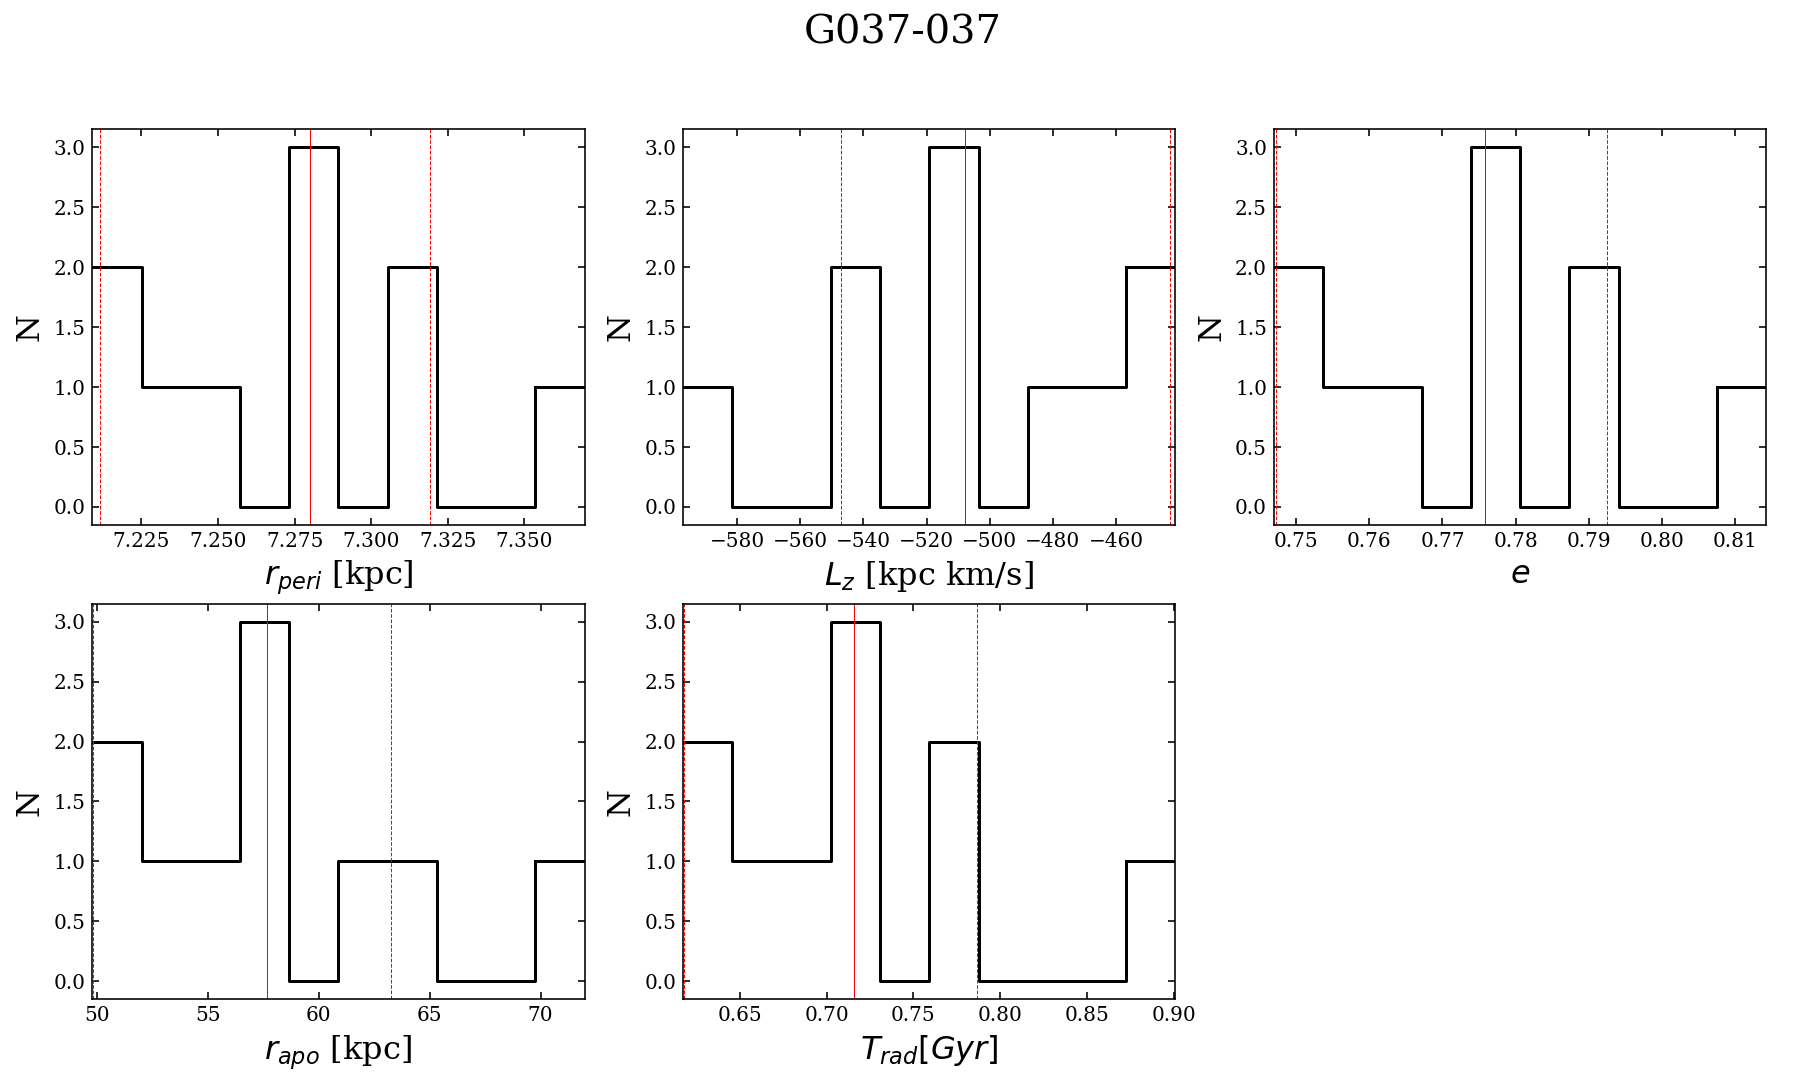

G037-037
rp [kpc]
Median: 7.2799
Central 68th percentile: [7.2113,7.2113]
Errors: [0.0685,0.0391]

rapo [kpc]
Median: 57.6463
Central 68th percentile: [49.8334,49.8334]
Errors: [7.8129,5.5899]

Lz [kpc km/s]
Median: -507.7555
Central 68th percentile: [-547.0533,-547.0533]
Errors: [39.2978,64.7597]

Tr [Gyr]
Median: 0.7156
Central 68th percentile: [0.6179,0.6179]
Errors: [0.0977,0.0713]

eccen.
Median: 0.7757
Central 68th percentile: [0.7472,0.7472]
Errors: [0.0285,0.0168]



A Jupyter Widget

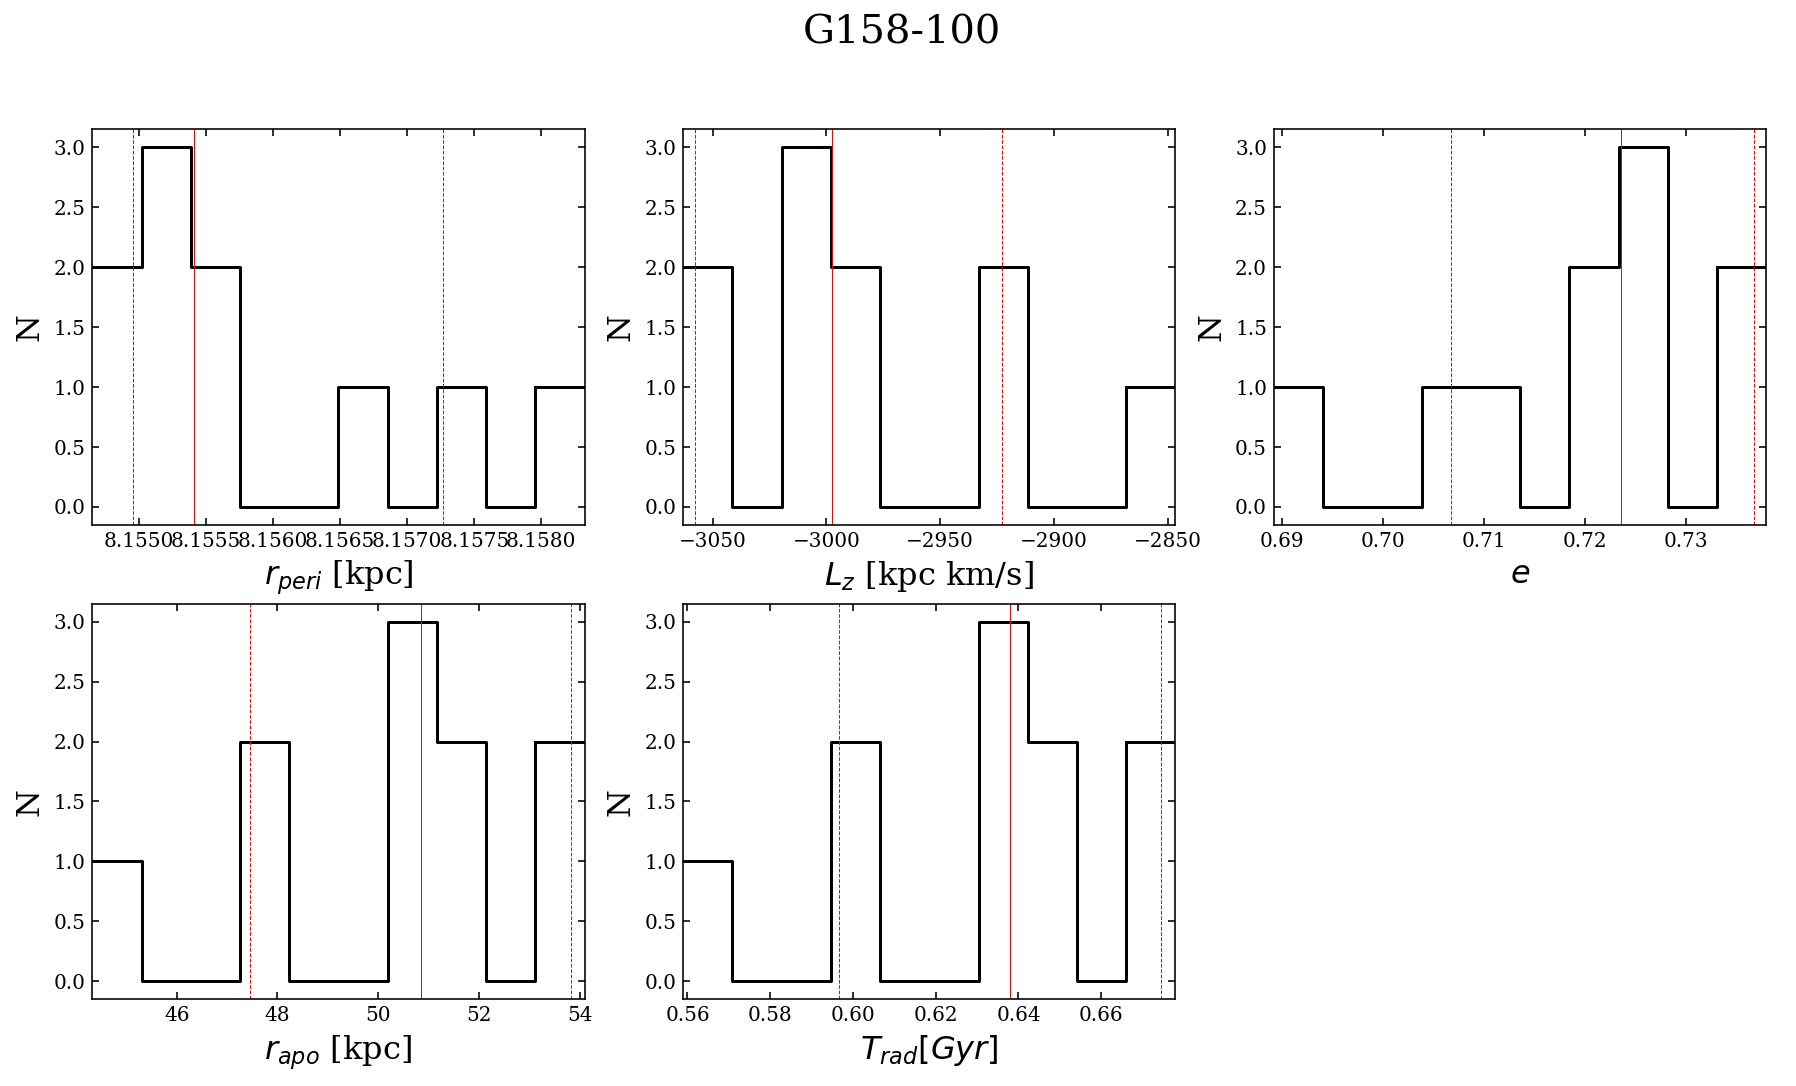

G158-100
rp [kpc]
Median: 8.1554
Central 68th percentile: [8.155,8.155]
Errors: [0.0005,0.0019]

rapo [kpc]
Median: 50.8504
Central 68th percentile: [47.4569,47.4569]
Errors: [3.3935,2.9635]

Lz [kpc km/s]
Median: -2997.7113
Central 68th percentile: [-3057.5288,-3057.5288]
Errors: [59.8175,74.6731]

Tr [Gyr]
Median: 0.638
Central 68th percentile: [0.5966,0.5966]
Errors: [0.0414,0.0365]

eccen.
Median: 0.7236
Central 68th percentile: [0.7067,0.7067]
Errors: [0.0168,0.0131]



A Jupyter Widget

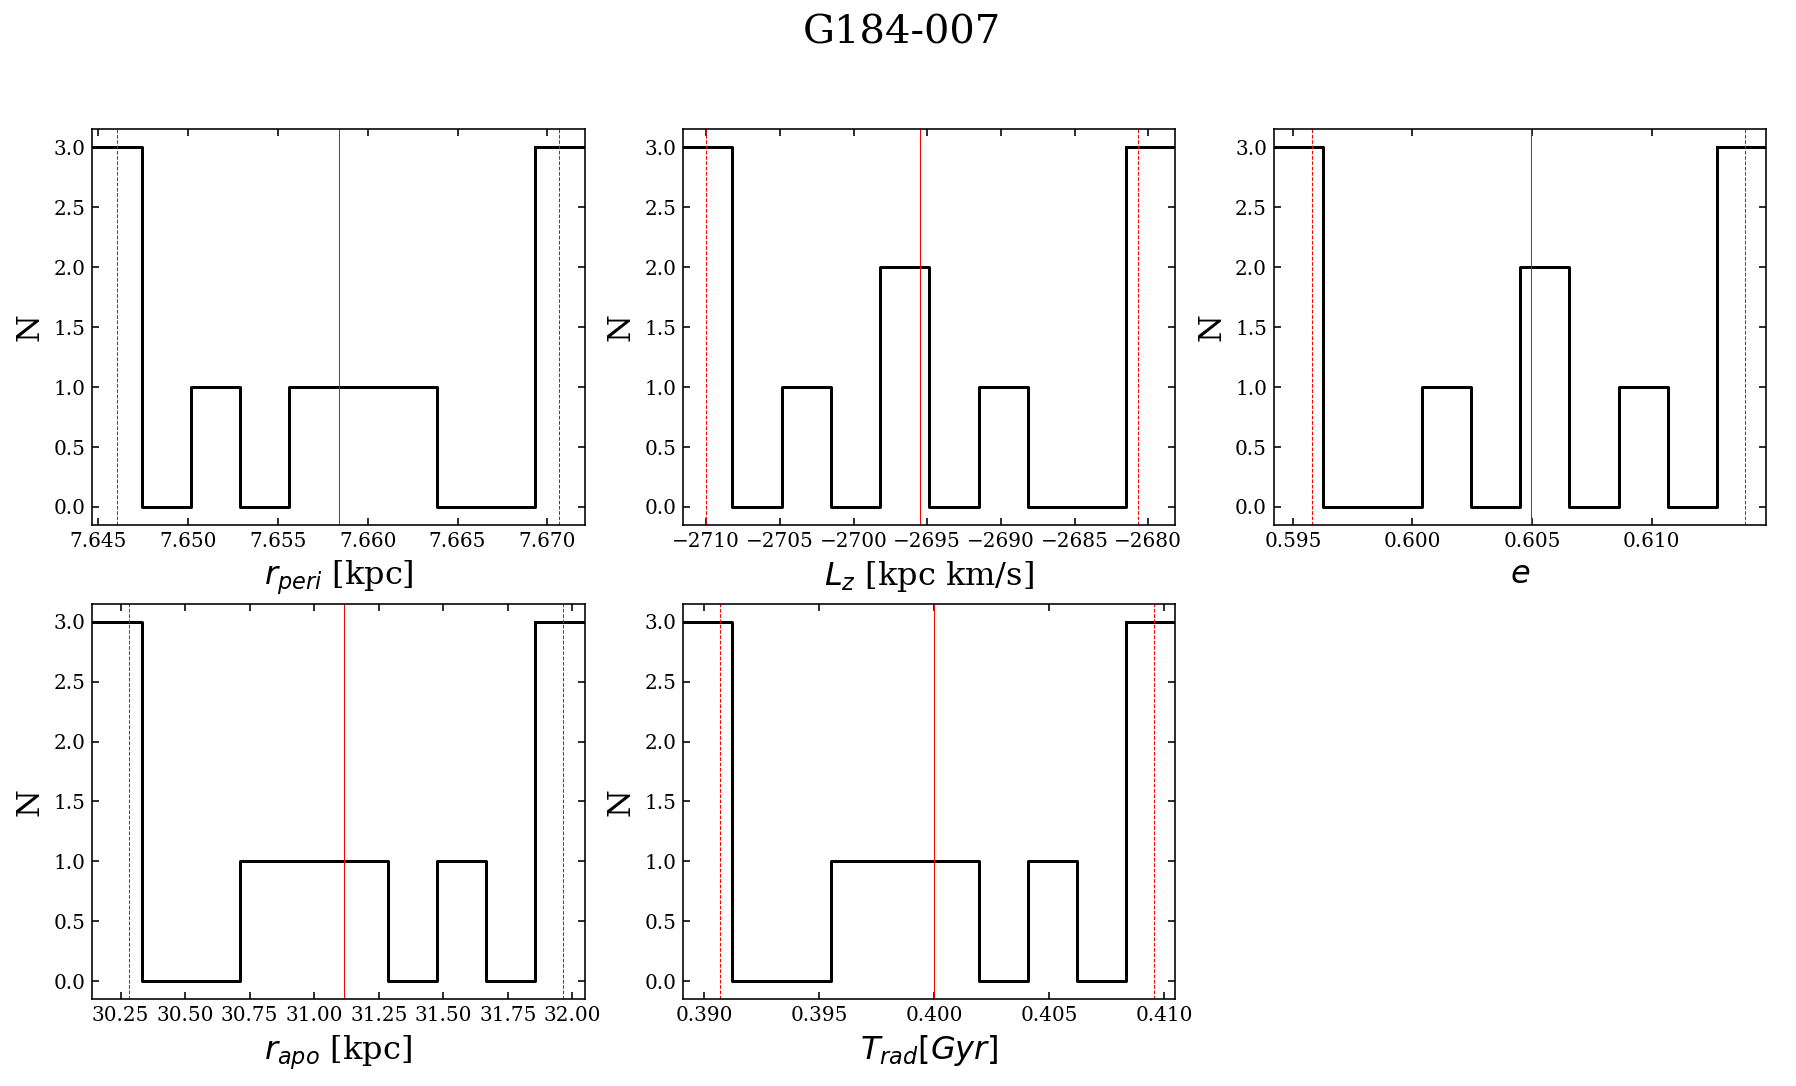

G184-007
rp [kpc]
Median: 7.6584
Central 68th percentile: [7.646,7.646]
Errors: [0.0124,0.0122]

rapo [kpc]
Median: 31.1136
Central 68th percentile: [30.282,30.282]
Errors: [0.8316,0.849]

Lz [kpc km/s]
Median: -2695.4962
Central 68th percentile: [-2710.0421,-2710.0421]
Errors: [14.5459,14.796]

Tr [Gyr]
Median: 0.4
Central 68th percentile: [0.3907,0.3907]
Errors: [0.0093,0.0096]

eccen.
Median: 0.605
Central 68th percentile: [0.5958,0.5958]
Errors: [0.0092,0.009]



A Jupyter Widget

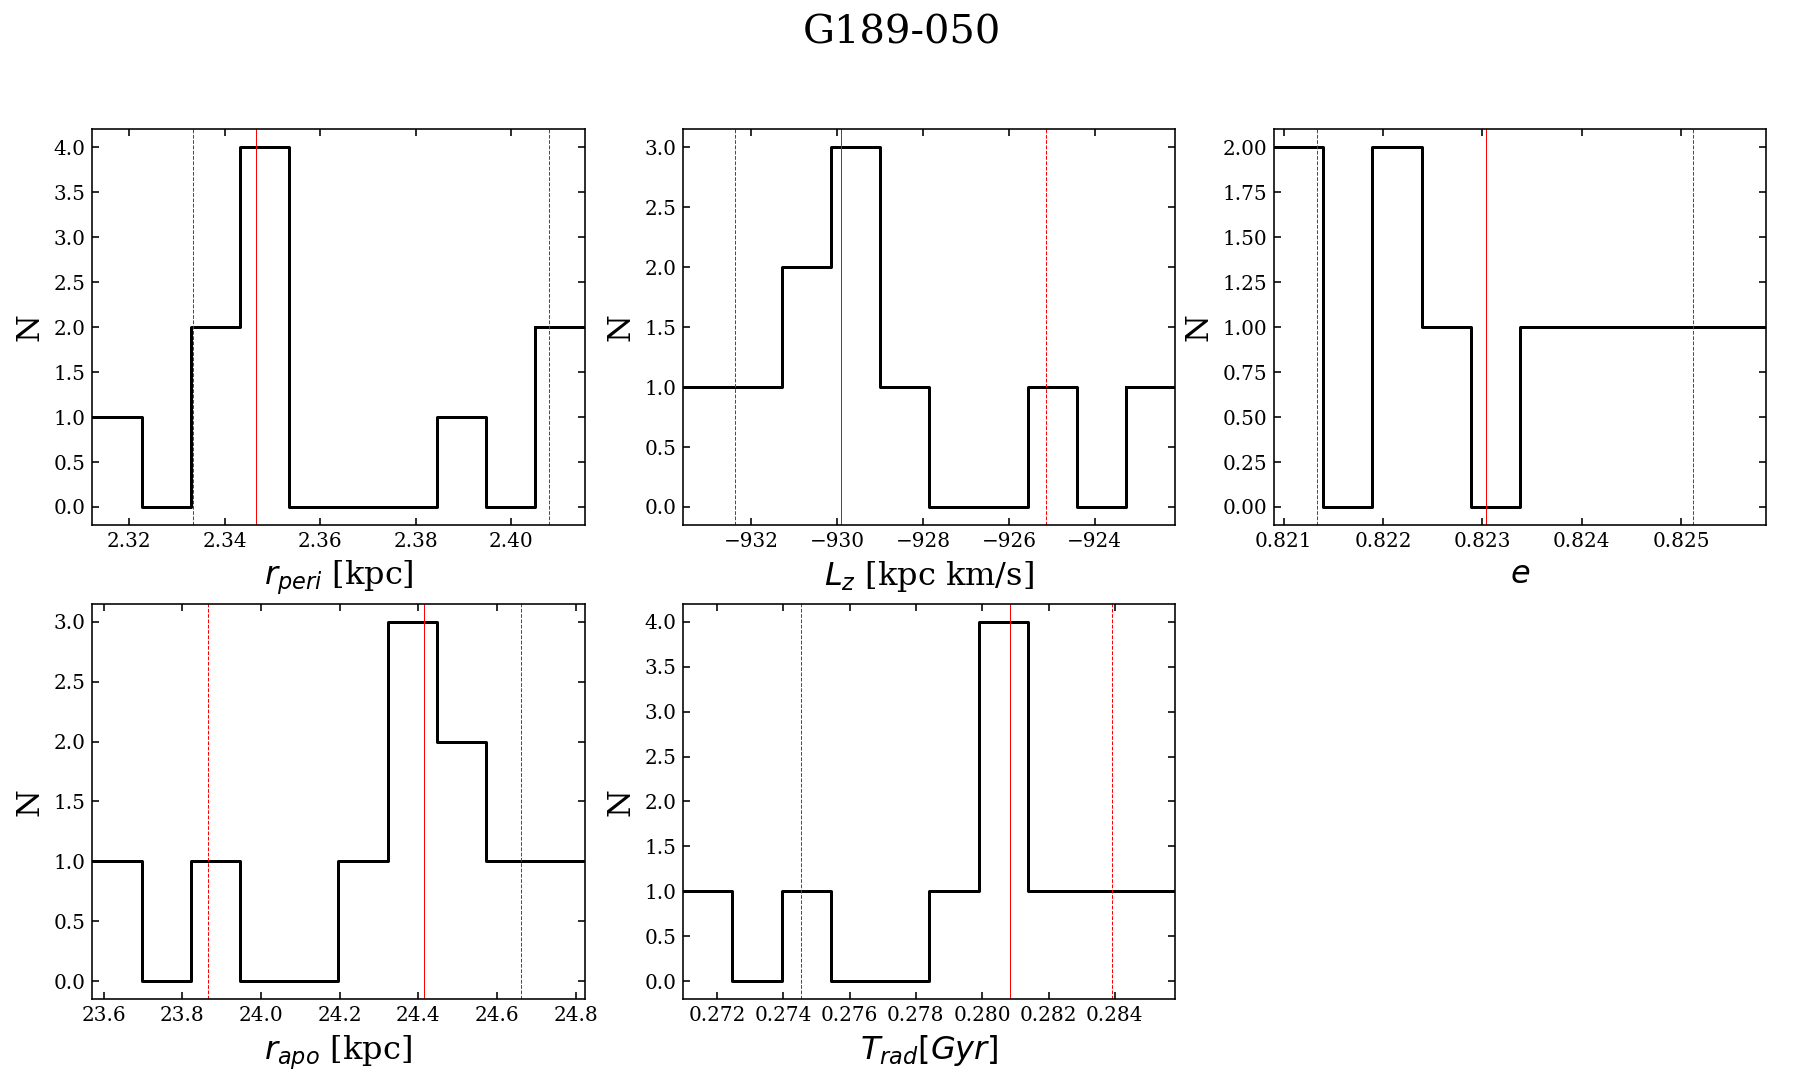

G189-050
rp [kpc]
Median: 2.3465
Central 68th percentile: [2.3334,2.3334]
Errors: [0.0131,0.0614]

rapo [kpc]
Median: 24.4152
Central 68th percentile: [23.8658,23.8658]
Errors: [0.5494,0.2443]

Lz [kpc km/s]
Median: -929.9183
Central 68th percentile: [-932.3726,-932.3726]
Errors: [2.4543,4.7733]

Tr [Gyr]
Median: 0.2808
Central 68th percentile: [0.2745,0.2745]
Errors: [0.0063,0.0031]

eccen.
Median: 0.823
Central 68th percentile: [0.8213,0.8213]
Errors: [0.0017,0.0021]



A Jupyter Widget

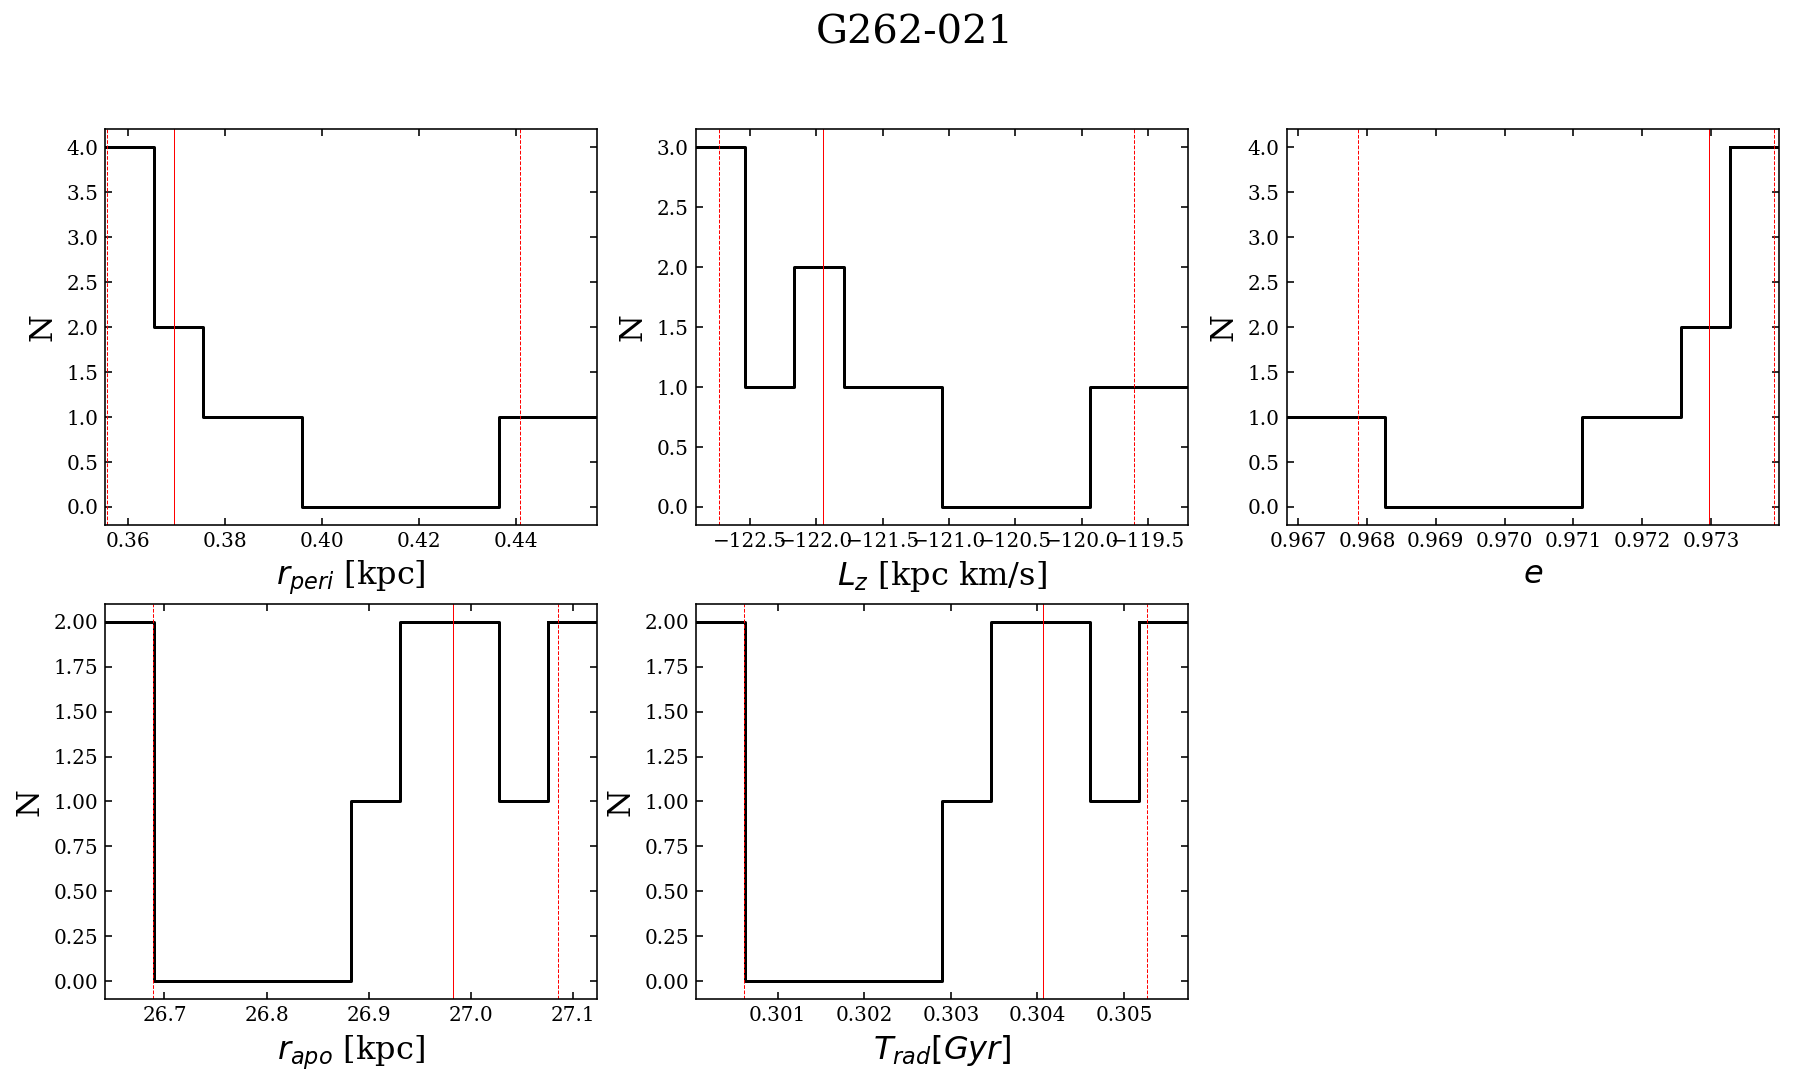

G262-021
rp [kpc]
Median: 0.3695
Central 68th percentile: [0.3557,0.3557]
Errors: [0.0137,0.0713]

rapo [kpc]
Median: 26.9822
Central 68th percentile: [26.6889,26.6889]
Errors: [0.2932,0.1026]

Lz [kpc km/s]
Median: -121.95
Central 68th percentile: [-122.7306,-122.7306]
Errors: [0.7806,2.3438]

Tr [Gyr]
Median: 0.3041
Central 68th percentile: [0.3006,0.3006]
Errors: [0.0035,0.0012]

eccen.
Median: 0.973
Central 68th percentile: [0.9679,0.9679]
Errors: [0.0051,0.0009]



In [62]:
# Evaluate
m17_stats = evaluate_orbit_parameters(ohstars.potential.McMillan2017, 'McMillan2017', 
                          10, star_names, tab, vrad, vrad_err, 
                          include_stars)
make_latex_table( m17_stats, star_names, filename='Mcmillan2017.txt' )